### Real Options Valuation and Monte Carlo simulation, DM and FPOM.

**This is a sheet for working with all three cases investigated in Santeri's Master thesis on Real Options.**

Combining previously modeled calculations into a single Python-enabled Jupyter notebook. Generalizing, modularizing and improving outputs.

**Note:** To avoid errors ensure all notebook cells are executed sequentially. 

### Setup

Implemented using the Conda kernel. Python version 3.9.18

In [2]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D


# Model and declare initial application state
case_data = {
    i: {
        "yearly_cash_flows": {
            "low": np.array([]),
            "base": np.array([]),
            "high": np.array([])
        },
        "cumulative_cash_flows": {
            "low": np.array([]),
            "base": np.array([]),
            "high": np.array([])
        },
        "case_npvs": np.array([]),
        "inputs": {},
        "DM_ROV": None,
        "FPOM_ROV": None,
    } for i in range(1, 4)
}


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Utilities

This section implements some of the necessary utility functions used later in this notebook.

In [3]:
# This function processes a string of pasted spreadsheet cells and returns a numpy array
def import_pasted_spreadsheet_cells(pasted_cells):
    data = pasted_cells.replace(",", ".")
    data_list = data.split()
    data_floats = [float(x) for x in data_list]
    return np.array(data_floats)

# This function helps form total discounted values for projects out of yearly cash flow values before simulation
def calculate_discounted_values(values_dict, risk_rate, start_period, periods_in_operation):
    # If the passed in values are launch costs, then we spread the that and discount it only for the years before launch.
    return {k: sum(v / (1 + risk_rate) ** period for period in range(start_period + 1, start_period + 1 + periods_in_operation)) for k, v in values_dict.items()}

### Import case data

Supports simple copy-pasting for long spreadsheet rows. All three cases are imported below.

In [4]:
# Import data for Case 1: Paptic product R&D
case_data[1]["yearly_cash_flows"]["low"] = import_pasted_spreadsheet_cells("0,00	0,00	-7,34	0,83	0,74	0,66	0,59	0,53") # pessimistic scenario
case_data[1]["yearly_cash_flows"]["base"] = import_pasted_spreadsheet_cells("0,00	0,00	-6,05	1,27	1,13	1,01	0,90	0,81") # base case scenario
case_data[1]["yearly_cash_flows"]["high"] = import_pasted_spreadsheet_cells("0,00	0,00	-4,75	2,64	2,35	2,10	1,88	1,68") # optimistic scenario
case_data[1]["inputs"]["start_operating_after_periods"] = 3 # After this amount of years operation starts
case_data[1]["inputs"]["periods_in_operation"] = 5 # Years of operation when launched and operating
case_data[1]["inputs"]["operating_risk_rate"] = 0.12 # Risk, hurdle or discount rate for operating cash flows
case_data[1]["inputs"]["launch_cost_risk_rate"] = 0.05 # Risk, hurdle or discount rate for launch costs
case_data[1]["inputs"]["yearly_op_revenues_range"] = {"pess": 2.5, "base": 3, "opti": 5} # Range of yearly operating revenues -> pess: pessimistic, base: base case, opti: optimistic
case_data[1]["inputs"]["yearly_op_cost_range"] = {"pess": 1.2, "base": 1, "opti": 0.85} # Range of yearly operating costs -> pess: pessimistic, base: base case, opti: optimistic
case_data[1]["inputs"]["total_launch_cost_range"] = {"pess": 8.5, "base": 7, "opti": 5.5} # Range of total launch costs -> pess: pessimistic, base: base case, opti: optimistic

# Import data for Case 2: Callio energy storage system
case_data[2]["yearly_cash_flows"]["low"] = import_pasted_spreadsheet_cells("-19,42	-18,85	4,90	4,58	4,28	4,00	3,74	3,49	3,26	3,05	2,85	2,66	2,49	2,33	2,17	2,03	1,90	1,78	1,66	1,55	1,45	1,35	1,27	1,18	1,11	1,03	0,97	0,90	0,84	0,79	0,74	0,69	0,64	0,60	0,56	0,53	0,49	0,46	0,43	0,40	0,37	0,35	0,33	0,31	0,29	0,27	0,25	0,23	0,22	0,20	0,19	0,18") # pessimistic scenario
case_data[2]["yearly_cash_flows"]["base"] = import_pasted_spreadsheet_cells("-16,99	-16,50	6,82	6,38	5,96	5,57	5,21	4,87	4,55	4,25	3,97	3,71	3,47	3,24	3,03	2,83	2,65	2,47	2,31	2,16	2,02	1,89	1,76	1,65	1,54	1,44	1,35	1,26	1,18	1,10	1,03	0,96	0,90	0,84	0,78	0,73	0,68	0,64	0,60	0,56	0,52	0,49	0,46	0,43	0,40	0,37	0,35	0,32	0,30	0,28	0,27	0,25") # base case scenario
case_data[2]["yearly_cash_flows"]["high"] = import_pasted_spreadsheet_cells("-14,56	-14,14	7,89	7,37	6,89	6,44	6,02	5,62	5,25	4,91	4,59	4,29	4,01	3,75	3,50	3,27	3,06	2,86	2,67	2,50	2,33	2,18	2,04	1,90	1,78	1,66	1,55	1,45	1,36	1,27	1,19	1,11	1,04	0,97	0,90	0,85	0,79	0,74	0,69	0,65	0,60	0,56	0,53	0,49	0,46	0,43	0,40	0,38	0,35	0,33	0,31	0,29") # optimistic scenario
case_data[2]["inputs"]["start_operating_after_periods"] = 2 # After this amount of years operation starts
case_data[2]["inputs"]["periods_in_operation"] = 50 # Years of operation when launched and operating
case_data[2]["inputs"]["operating_risk_rate"] = 0.07 # Risk, hurdle or discount rate for operating cash flows
case_data[2]["inputs"]["launch_cost_risk_rate"] = 0.03 # Risk, hurdle or discount rate for launch costs
case_data[2]["inputs"]["yearly_op_revenues_range"] = {"pess": 7.5, "base": 9.5, "opti": 10.5} # Range of yearly operating revenues -> pess: pessimistic, base: base case, opti: optimistic
case_data[2]["inputs"]["yearly_op_cost_range"] = {"pess": 1.5, "base": 1.14, "opti": 0.84} # Range of yearly operating costs -> pess: pessimistic, base: base case, opti: optimistic
case_data[2]["inputs"]["total_launch_cost_range"] = {"pess": 40, "base": 35, "opti": 30} # Range of total launch costs -> pess: pessimistic, base: base case, opti: optimistic

# Import data for Case 3: Power Coast international JV
case_data[3]["yearly_cash_flows"]["low"] = import_pasted_spreadsheet_cells("-420,56	    -393,05	61,26	49,81	40,49	32,92	26,77	21,76	17,69	14,38	11,69	9,51") # pessimistic scenario
case_data[3]["yearly_cash_flows"]["base"] = import_pasted_spreadsheet_cells("-361,68	-338,02	233,57	189,90	154,39	125,52	102,05	82,97	67,45	54,84	44,58	36,25") # base case scenario
case_data[3]["yearly_cash_flows"]["high"] = import_pasted_spreadsheet_cells("-327,10	-305,70	335,33	272,62	221,65	180,20	146,50	119,11	96,84	78,73	64,01	52,04") # optimistic scenario
case_data[3]["inputs"]["start_operating_after_periods"] = 2 # After this amount of years operation starts
case_data[3]["inputs"]["periods_in_operation"] = 10 # Years of operation when launched and operating
case_data[3]["inputs"]["operating_risk_rate"] = 0.23 # Risk, hurdle or discount rate for operating cash flows
case_data[3]["inputs"]["launch_cost_risk_rate"] = 0.07 # Risk, hurdle or discount rate for launch costs
case_data[3]["inputs"]["yearly_op_revenues_range"] = {"pess": 570, "base": 1037.67, "opti": 1092} # Range of yearly operating revenues -> pess: pessimistic, base: base case, opti: optimistic
case_data[3]["inputs"]["yearly_op_cost_range"] = {"pess": 456, "base": 603, "opti": 468} # Range of yearly operating costs -> pess: pessimistic, base: base case, opti: optimistic
case_data[3]["inputs"]["total_launch_cost_range"] = {"pess": 900, "base": 774, "opti": 700} # Range of total launch costs -> pess: pessimistic, base: base case, opti: optimistic

# Applies only to the third business case: Adjust cash flows for Finnish government share of JV
case_data[3]["yearly_cash_flows"]["low"] *= 0.3
case_data[3]["yearly_cash_flows"]["base"] *= 0.3
case_data[3]["yearly_cash_flows"]["high"] *= 0.3

### Visualization 1: Plot the three investments

Below code displays all three investments.

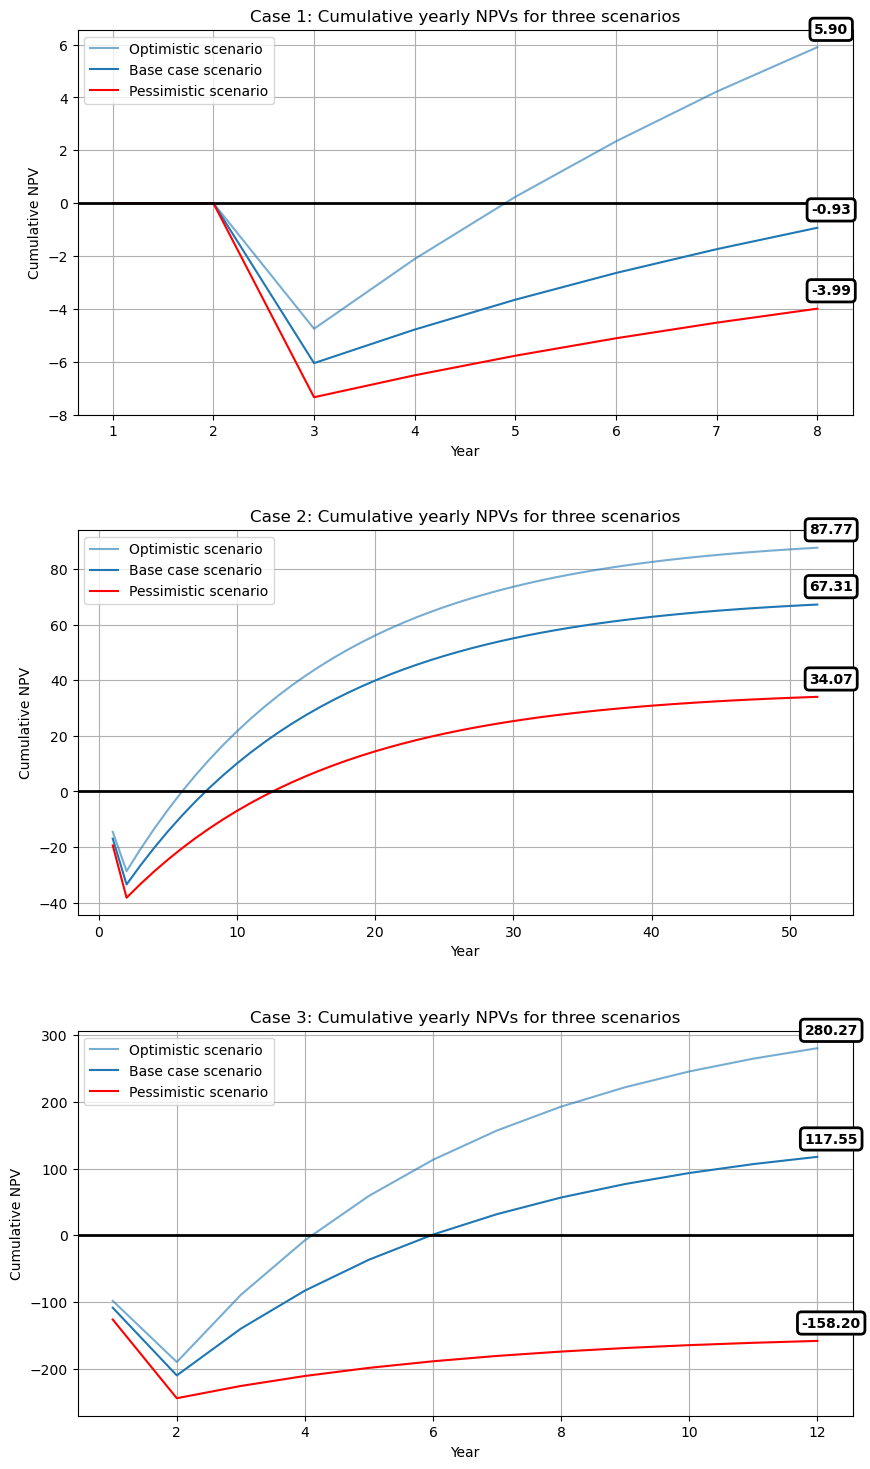

In [5]:
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

for i, ax in enumerate(axs, start=1):
    case_data[i]["cumulative_cash_flows"]["low"] = np.cumsum(case_data[i]["yearly_cash_flows"]["low"])
    case_data[i]["cumulative_cash_flows"]["base"] = np.cumsum(case_data[i]["yearly_cash_flows"]["base"])
    case_data[i]["cumulative_cash_flows"]["high"] = np.cumsum(case_data[i]["yearly_cash_flows"]["high"])

    years = range(1, len(case_data[i]["yearly_cash_flows"]["low"]) + 1)

    ax.plot(years, case_data[i]["cumulative_cash_flows"]["high"], color='C0', alpha=0.6, label='Optimistic scenario')
    ax.plot(years, case_data[i]["cumulative_cash_flows"]["base"], color='C0', label='Base case scenario')
    ax.plot(years, case_data[i]["cumulative_cash_flows"]["low"], color='red', label='Pessimistic scenario')

    ax.axhline(0, color='black', linewidth=2)

    bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=2)
    ax.annotate(f'{case_data[i]["cumulative_cash_flows"]["low"][-1]:.2f}', (years[-1], case_data[i]["cumulative_cash_flows"]["low"][-1]), textcoords="offset points", xytext=(10,10), ha='center', fontsize=10, fontweight='bold', bbox=bbox_props)
    ax.annotate(f'{case_data[i]["cumulative_cash_flows"]["base"][-1]:.2f}', (years[-1], case_data[i]["cumulative_cash_flows"]["base"][-1]), textcoords="offset points", xytext=(10,10), ha='center', fontsize=10, fontweight='bold', bbox=bbox_props)
    ax.annotate(f'{case_data[i]["cumulative_cash_flows"]["high"][-1]:.2f}', (years[-1], case_data[i]["cumulative_cash_flows"]["high"][-1]), textcoords="offset points", xytext=(10,10), ha='center', fontsize=10, fontweight='bold', bbox=bbox_props)

    ax.set_xlabel('Year')
    ax.set_ylabel('Cumulative NPV')
    ax.set_title(f'Case {i}: Cumulative yearly NPVs for three scenarios')
    ax.legend()
    ax.grid(True)

plt.subplots_adjust(hspace=0.3)
plt.show()

### Preparing for simulation

Run this cell before starting simulation to perform discounting and adjust unique parameters of some business cases.

In [6]:
# Loops through all cases and calculates discounted values for each investment forming sampling ranges for Monte Carlo simulation
for case_number, case in enumerate(case_data.values(), start=1):
    inputs = case["inputs"]
    # First we discount and sum operating revenues, then do the same for operating costs. For all cases we calculate the discounted launch costs spread evenly across the years before launch
    case["inputs"]["total_op_revenues"] = calculate_discounted_values(inputs["yearly_op_revenues_range"], inputs["operating_risk_rate"], inputs["start_operating_after_periods"], inputs["periods_in_operation"])
    case["inputs"]["total_op_costs"] = calculate_discounted_values(inputs["yearly_op_cost_range"], inputs["operating_risk_rate"], inputs["start_operating_after_periods"], inputs["periods_in_operation"])
    case["inputs"]["launch_cost"] = {k: sum((v / inputs["start_operating_after_periods"]) / (1 + inputs["launch_cost_risk_rate"]) ** period for period in range(1, inputs["start_operating_after_periods"] + 1)) for k, v in inputs["total_launch_cost_range"].items()}

# Applies only to the third business case: This code adjusts to-be simulated values to consider only the Finnish government share of the joint venture
keys = ["total_op_revenues", "total_op_costs", "launch_cost"]
for key in keys:
    case_data[3]["inputs"][key] = {k: v * 0.3 for k, v in case_data[3]["inputs"][key].items()}

### Perform the Monte Carlo simulation

Defines the simulation and proceeds to run it for all three business cases.

In [7]:
# Define number of simulation runs
num_simulations = 100000

# Create a function to simulate a single draw or sample from a triangular distribution
def simulation_single_sample(pess, base, opti):
    # Logic to handle drawing the triangular distribution correctly
    low, mode, high = sorted([pess, base, opti])
    sample = np.random.triangular(low, mode, high)
    return sample

# Create a function for running the Monte Carlo simulation
def monte_carlo_simulation(launch_cost, total_op_revenues, total_op_costs, num_simulations):
    npvs = []
    for _ in range(num_simulations):
        simul_launch_cost = simulation_single_sample(launch_cost["pess"], launch_cost["base"], launch_cost["opti"])
        simul_operating_inflows = simulation_single_sample(total_op_revenues["pess"], total_op_revenues["base"], total_op_revenues["opti"])
        simul_operating_outflows = simulation_single_sample(total_op_costs["pess"], total_op_costs["base"], total_op_costs["opti"])

        # Out of all investment inflows substract its launch cost and total operating outflows
        npv = simul_operating_inflows - (simul_launch_cost + simul_operating_outflows)
        npvs.append(npv)
    return npvs

# Run simulations and store results each case's "case npvs" array
case_data[1]["case_npvs"] = monte_carlo_simulation(case_data[1]["inputs"]["launch_cost"], case_data[1]["inputs"]["total_op_revenues"], case_data[1]["inputs"]["total_op_costs"], num_simulations)
case_data[2]["case_npvs"] = monte_carlo_simulation(case_data[2]["inputs"]["launch_cost"], case_data[2]["inputs"]["total_op_revenues"], case_data[2]["inputs"]["total_op_costs"], num_simulations)
case_data[3]["case_npvs"] = monte_carlo_simulation(case_data[3]["inputs"]["launch_cost"], case_data[3]["inputs"]["total_op_revenues"], case_data[3]["inputs"]["total_op_costs"], num_simulations)

### Applying DM-method to derive the ROV for each case

Prints output ROV values of the DM-method below. 

In [8]:
for i in range(1, 4):
    npvs = case_data[i]["case_npvs"]

    # Filter the NPVs to only include the positive ones
    npvs_positive = [npv for npv in npvs if npv > 0]

    # Calculate the mean of the positive NPVs
    npv_positive_adjusted_mean = np.mean(npvs_positive)

    # Calculate the proportion of positive outcomes
    proportion_positive_adjusted = len(npvs_positive) / num_simulations

    # Adjust the mean by the proportion of positive outcomes
    npv_adjusted = npv_positive_adjusted_mean * proportion_positive_adjusted

    # Store the npv_adjusted value
    case_data[i]["DM_ROV"] = round(npv_adjusted, 2)

    print(" ")
    print(f"Case {i}:")
    print(f"Non-risk adjusted NPV is {round(npv_positive_adjusted_mean, 2)}")
    print(f"The Datar-Mathews ROV is {round(npv_adjusted, 2)} (risk-adjusted mean NPV)")

 
Case 1:
Non-risk adjusted NPV is 1.35
The Datar-Mathews ROV is 0.63 (risk-adjusted mean NPV)
 
Case 2:
Non-risk adjusted NPV is 63.06
The Datar-Mathews ROV is 63.06 (risk-adjusted mean NPV)
 
Case 3:
Non-risk adjusted NPV is 116.88
The Datar-Mathews ROV is 92.22 (risk-adjusted mean NPV)


### Visualization 2: Show resulting NPV outcome distributions for each business case

Below code displays all three investments. The lighter area of the distribution describes negative NPV outcomes

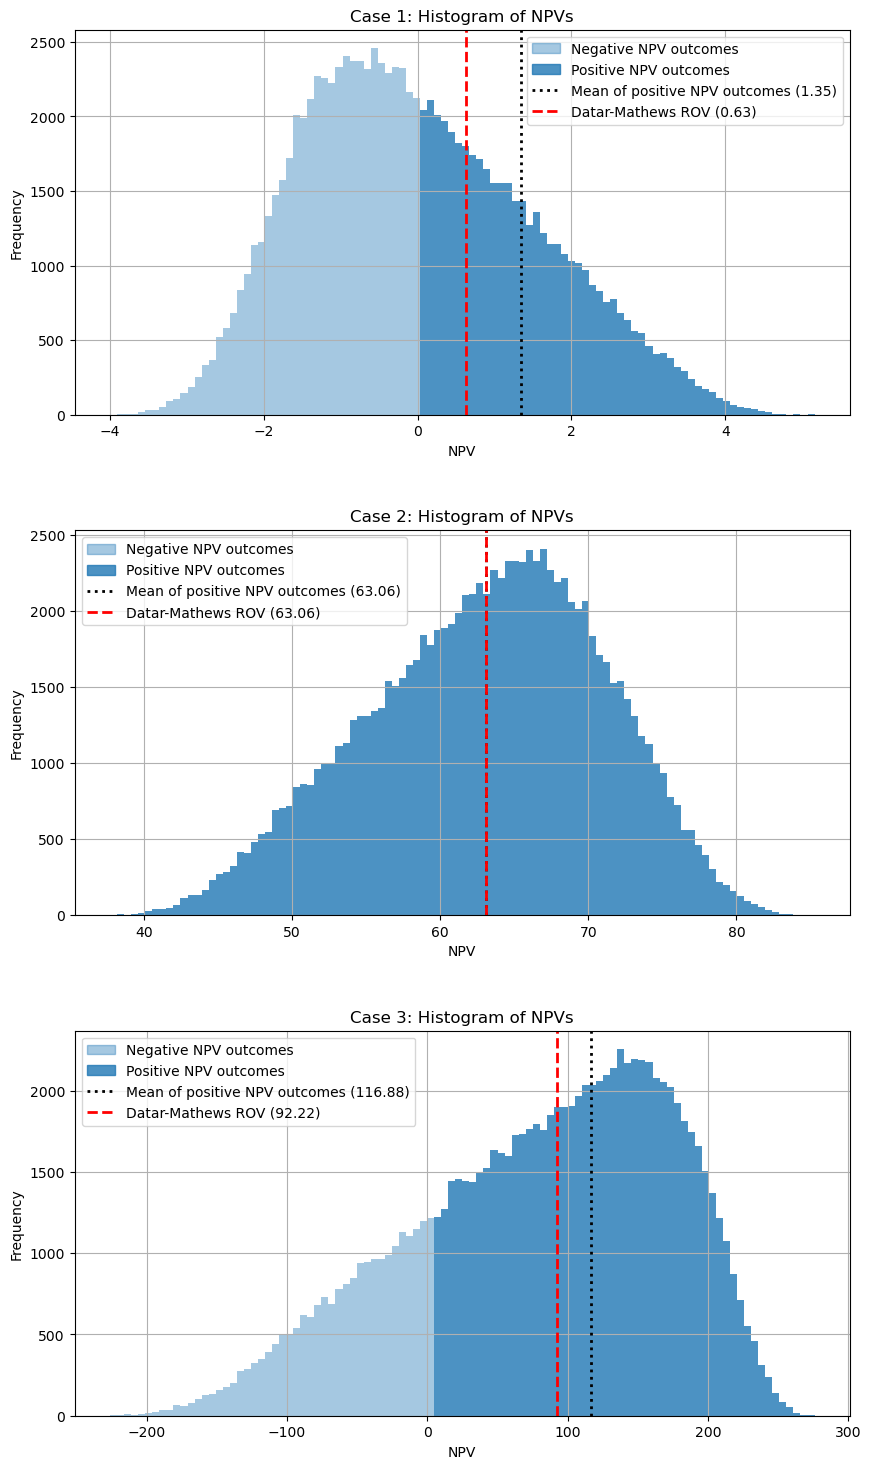

In [9]:
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

for i, ax in enumerate(axs, start=1):
    npvs = case_data[i]["case_npvs"]

    counts, bins, patches = ax.hist(npvs, bins=100, alpha=0.8)

    for count, bin, patch in zip(counts, bins, patches):
        if bin < 0:
            patch.set_alpha(0.4)  # Decrease the opacity

    npvs_positive = [npv for npv in npvs if npv > 0]
    npv_positive_mean = np.mean(npvs_positive)

    proportion_positive_adjusted = len(npvs_positive) / num_simulations

    npv_adjusted = npv_positive_mean * proportion_positive_adjusted

    ax.axvline(npv_positive_mean, color='black', linestyle='dotted', linewidth=2, label=f'Mean of positive NPV outcomes ({npv_positive_mean:.2f})')

    ax.axvline(npv_adjusted, color='red', linestyle='dashed', linewidth=2, label=f'Datar-Mathews ROV ({npv_adjusted:.2f})')

    patch1 = mpatches.Patch(color='C0', alpha=0.4, label='Negative NPV outcomes')
    patch2 = mpatches.Patch(color='C0', alpha=0.8, label='Positive NPV outcomes')
    line1 = Line2D([0], [0], color='black', lw=2, linestyle='dotted', label=f'Mean of positive NPV outcomes ({npv_positive_mean:.2f})')
    line2 = Line2D([0], [0], color='red', lw=2, linestyle='dashed', label=f'Datar-Mathews ROV ({npv_adjusted:.2f})')

    ax.legend(handles=[patch1, patch2, line1, line2])

    ax.set_xlabel('NPV')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Case {i}: Histogram of NPVs')
    ax.grid(True)

plt.subplots_adjust(hspace=0.3)
plt.show()

### Applying FPOM-method to derive the ROV for each case

First cell declares necessary functions, and second cell calculates the ROV values for each case.

In [10]:
# Declare functions used for calculating correct alpha and beta needed for FPOM method
def calculate_fpom_alpha(low, base):
    if low < 0:
        return abs(low) + abs(base)
    else:
        return abs(base) - abs(low)
    
def calculate_fpom_beta(base, high):
    if base < 0:
        return abs(high) + abs(base)
    else:
        return abs(high) - abs(base)
    
# Declare functions used for calculating FPOM ROV in different mathematical cases as stipulated by theory
def calculate_fpom_case_1():
    return 0

def calculate_fpom_case_2(fpom_a, fpom_beta):
    return round((fpom_a**3)/(6*fpom_beta**2) + (fpom_a**2)/(2*fpom_beta) + fpom_a/2 + fpom_beta/6, 2)

def calculate_fpom_case_3(fpom_a, fpom_alpha, fpom_beta):
    return round(-(fpom_a**3)/(6*fpom_alpha**2) + (fpom_a**2)/(2*fpom_alpha) + fpom_a/2 + fpom_beta/6, 2)

def calculate_fpom_case_4(fpom_a, fpom_alpha, fpom_beta):
    return round(fpom_a + (fpom_beta - fpom_alpha) / 6, 2)

# Declare function used for calculating correct FPOM POSROV value based on each cases expected scenario outcomes
def calculate_final_fpom_rov(pess, base, opti, fpom_a, fpom_alpha, fpom_beta):
    if pess <= 0 and base <= 0 and opti <= 0:
        return calculate_fpom_case_1()
    elif pess <= 0 and base <= 0 and opti > 0:
        return calculate_fpom_case_2(fpom_a, fpom_beta)
    elif pess <= 0 and base > 0 and opti > 0:
        return calculate_fpom_case_3(fpom_a, fpom_alpha, fpom_beta)
    elif pess > 0 and base > 0 and opti > 0:
        return calculate_fpom_case_4(fpom_a, fpom_alpha, fpom_beta)

In [11]:
# Declare a store for case values
case_values = {}

# Pick out the final cumulative cash flow values for each case
for i in range(1, 4):
    case_values[f"case_{i}_low"] = round(case_data[i]["cumulative_cash_flows"]["low"][-1], 2)
    case_values[f"case_{i}_base"] = round(case_data[i]["cumulative_cash_flows"]["base"][-1], 2)
    case_values[f"case_{i}_high"] = round(case_data[i]["cumulative_cash_flows"]["high"][-1], 2)

    # Calculate necessary variables for FPOM method 
    case_values[f"case_{i}_fpom_a"] = case_values[f"case_{i}_base"]
    case_values[f"case_{i}_fpom_alpha"] = round(calculate_fpom_alpha(case_values[f"case_{i}_low"], case_values[f"case_{i}_base"]), 2)
    case_values[f"case_{i}_fpom_beta"] = round(calculate_fpom_beta(case_values[f"case_{i}_base"], case_values[f"case_{i}_high"]), 2)

    # Calculate ROV
    case_values[f"case_{i}_ROV"] = calculate_final_fpom_rov(case_values[f"case_{i}_low"], case_values[f"case_{i}_base"], case_values[f"case_{i}_high"], case_values[f"case_{i}_fpom_a"], case_values[f"case_{i}_fpom_alpha"], case_values[f"case_{i}_fpom_beta"])

    # Store the npv_adjusted value into case_data[i]["DM_ROV"]
    case_data[i]["FPOM_ROV"] = case_values[f"case_{i}_ROV"]

    # Print out results
    print(f"Case {i} FPOM ROV: {case_values[f'case_{i}_ROV']}")

Case 1 FPOM ROV: 0.73
Case 2 FPOM ROV: 65.18
Case 3 FPOM ROV: 107.39


### Visualization 3: Show possibilistic fuzzy payoff distributions for each business case

Below code displays all three investments.

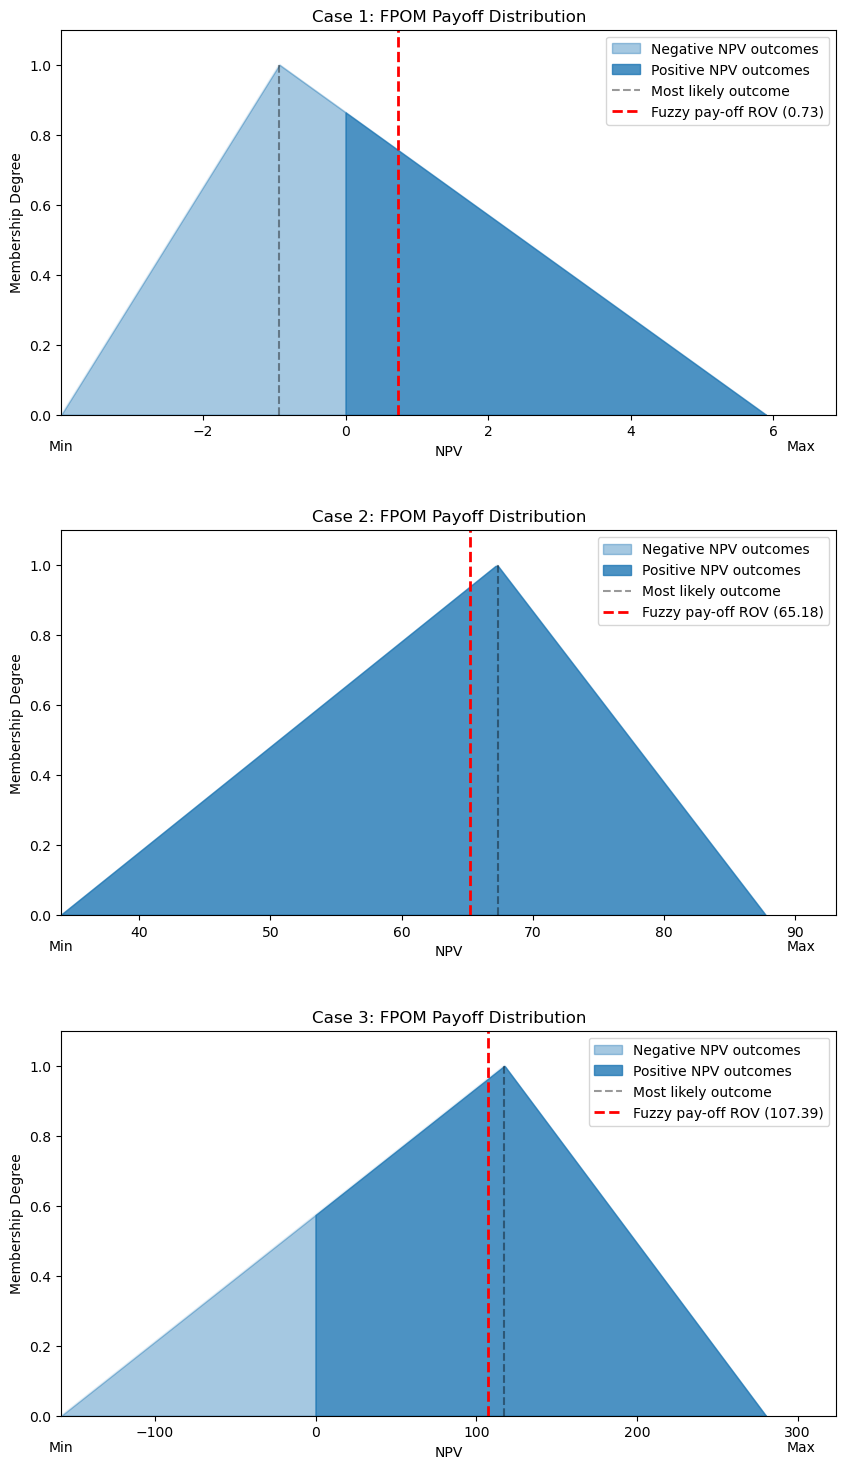

In [25]:
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

for i, ax in enumerate(axs, start=1):
    low = case_values[f"case_{i}_low"]
    base = case_values[f"case_{i}_base"]
    high = case_values[f"case_{i}_high"]
    x = [low, base, high]
    y = [0, 1, 0]

    ax.plot(x, y, color='C0', alpha=0.1)

    x_negative = np.linspace(low, 0, 500)
    y_negative = np.interp(x_negative, x, y)
    x_positive = np.linspace(0, high, 500)
    y_positive = np.interp(x_positive, x, y)

    ax.fill_between(x_negative, y_negative, color='C0', alpha=0.4, label='Negative NPV outcomes')  # Add label for the legend
    ax.fill_between(x_positive, y_positive, color='C0', alpha=0.8, label='Positive NPV outcomes')  # Add label for the legend

    # Add a grey dotted line from the peak of the distribution to the x-axis with a label for the legend
    ax.plot([base, base], [0, 1], color='black', alpha=0.4, linestyle='dashed', label='Most likely outcome')

    # Add the Fuzzy pay-off method ROV value
    rov = case_values[f'case_{i}_ROV']
    ax.axvline(rov, color='red', linestyle='dashed', linewidth=2, label=f'Fuzzy pay-off ROV ({rov:.2f})')

    # Add labels for the min and max points
    ax.text(low, -0.07, 'Min', ha='center', va='top')
    ax.text(high + (high - low) * 0.05, -0.07, 'Max', ha='center', va='top')

    ax.set_xlabel('NPV')
    ax.set_ylabel('Membership Degree')

    ax.set_ylim(0, 1.1)

    ax.set_xlim(low, high + (high - low) * 0.1)

    ax.legend()

    ax.set_title(f'Case {i}: FPOM Payoff Distribution')

plt.subplots_adjust(hspace=0.3)
plt.show()

### Displaying a summary view of ROV calculations

In [259]:
for i in range(1, 4):
    dm_rov = case_data[i]['DM_ROV']
    fpom_rov = case_data[i]['FPOM_ROV']

    # Calculate the percentage difference
    percentage_difference = round(((fpom_rov - dm_rov) / dm_rov) * 100, 2)

    print(f"Business case {i}:")
    print(f"Datar-Mathews method ROV: {case_data[i]['DM_ROV']}")
    print(f"Fuzzy pay-off method ROV: {case_data[i]['FPOM_ROV']}")
    print(f"Percentage difference: {percentage_difference}%")
    print(" ")

Business case 1:
Datar-Mathews method ROV: 0.63
Fuzzy pay-off method ROV: 0.73
Percentage difference: 15.87%
 
Business case 2:
Datar-Mathews method ROV: 63.04
Fuzzy pay-off method ROV: 65.18
Percentage difference: 3.39%
 
Business case 3:
Datar-Mathews method ROV: 92.41
Fuzzy pay-off method ROV: 107.39
Percentage difference: 16.21%
 


##### Produced by Santeri Liukkonen at LUT University (2023)